GRNA Linear Mixed Effect model analysis code
Jinkook Yu
last edited : 2023 . 10 . 23
todo
1) first-order preprocessing : input block column & remove over 3SD RTs
2) discriptive plot

In [121]:
# Importing necessary libraries
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [58]:
file = pd.read_csv('./results/GRNA_2_2_2023_10_27_17_22_4.csv',  header = None)
file.columns = ['subject_id', 'trial', 'condition', 'resp', 'RT', 'corr']
full_values = file['condition'].value_counts()
print(full_values)

2    96
0    64
1    32
Name: condition, dtype: int64


In [75]:
drop_idx = file[(file['condition'] == 2) | (file['corr'] == 0)].index
file = file.drop(drop_idx)
drop_values = file['condition'].value_counts()

mean = file['RT'].mean()
std_dev = file['RT'].std()

# Creating a boolean mask to identify non-outliers
non_outliers = (file['RT'] >= mean - 3*std_dev) & (file['RT'] <= mean + 3*std_dev)

# Using the boolean mask to filter the dataframe
file = file[non_outliers]

nan


In [53]:
file

,subject_id,trial,condition,resp,RT,corr
2,4,3,0,2,0.98040,1
3,4,4,1,2,0.55840,1
5,4,6,0,2,0.58528,1
10,4,11,0,2,0.65853,1
11,4,12,1,2,1.05740,1
...,...,...,...,...,...,...
175,4,176,0,2,0.44159,1
176,4,177,0,2,0.52876,1
180,4,181,1,2,0.52081,1
187,4,188,0,2,0.41441,1


Text(0, 0.5, 'RT')

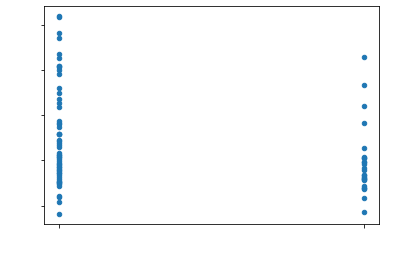

In [57]:
file.plot.scatter(x = 'condition', y = 'RT')
plt.xlabel('condition', color = 'white')
plt.xticks([0, 1], ['incongruent', 'congruent'], color = 'white')
plt.yticks(color = 'white')
plt.ylabel('RT', color = 'white')

In [18]:
# removing outlier function
def remove_outliers(group):
    mean = group['RT'].mean()
    std_dev = group['RT'].std()
    
    # Creating a boolean mask to identify non-outliers
    non_outliers = (group['RT'] >= mean - 3*std_dev) & (group['RT'] <= mean + 3*std_dev)
    
    # Using the boolean mask to filter the group
    return group[non_outliers]

In [111]:
# Creating a  DataFrame
path = './results/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

df = pd.DataFrame(columns=['condition', 'RT'])
missing_array = []

# for every csvs in exp results folder
for i in file_list_py:
    data = pd.read_csv(path + i, header = None)
    subjdf = pd.DataFrame(data)
    subjdf.columns = ['subject_id', 'trial', 'condition', 'resp', 'RT', 'corr']
    full_values = subjdf['condition'].value_counts()
    
    # data pre-processing
    drop_idx = subjdf[(subjdf['condition'] == 2) | (subjdf['corr'] == 0)].index
    subjdf = subjdf.drop(drop_idx)
    
    subjdf = subjdf.groupby('condition').apply(remove_outliers).reset_index(drop=True)
    missing_values = full_values - subjdf['condition'].value_counts()
    missing_array.append(missing_values[0])
    missing_array.append(missing_values[1])
    
    # append subject data to main data
    conditions = subjdf['condition'].unique()
    subject_id = str(subjdf['subject_id'].unique()[0])
    for condition in conditions:
         # Filtering the DataFrame based on the condition
        condition_df = subjdf[subjdf['condition'] == condition]
    
        # Calculating the mean
        cond_RT = condition_df['RT'].mean()
    
        # Appending the mean value to the empty DataFrame
        df = df.append({'subject_id': subject_id, 'condition': condition, 'RT': cond_RT}, ignore_index=True)

df['missing_values'] = missing_array
df['missing_values'] = df['missing_values'].astype('category')
print(df)

   condition        RT subject_id missing_values
0          0  0.589768          3            3.0
1          1  0.581273          3            0.0
2          0  0.435825         11            5.0
3          1  0.435965         11            1.0
4          0  0.537559         13            2.0
5          1  0.504904         13            3.0
6          0  0.664593         15            1.0
7          1  0.610628         15            1.0
8          0  0.547451          1            2.0
9          1  0.541481          1            1.0
10         0  0.452668          5            0.0
11         1  0.460098          5            4.0
12         0  0.541002          7            3.0
13         1  0.538229          7            1.0
14         0  0.495949          9            1.0
15         1  0.476212          9            2.0
16         0  0.540587          2            2.0
17         1  0.512475          2            0.0
18         0  0.708818          4            6.0
19         1  0.5913

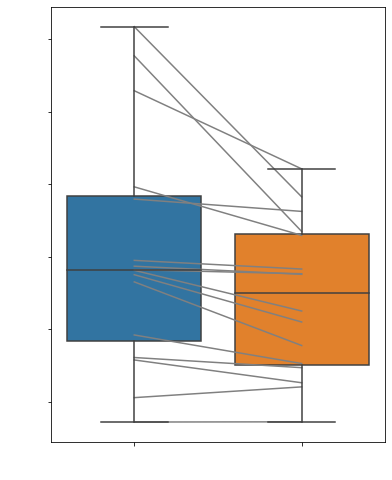

In [126]:
# Getting the unique subjects
subjects = df['subject_id'].unique()

# Creating a plot for each subject
plt.figure(figsize=(6, 8))
for subject in subjects:
    subject_data = df[df['subject_id'] == subject]
    plt.plot(subject_data['condition'], subject_data['RT'], label=f'Subject {subject}', color = 'gray')

sns.boxplot(x='condition', y='RT', data = df)

# Adding labels and title
plt.xlabel('condition', color = 'white')
plt.xticks([0, 1], ['incongruent', 'congruent'], color = 'white')
plt.yticks(color = 'white')
plt.ylabel('RT', color = 'white')

# Displaying the plot
plt.show()

In [116]:
model = smf.mixedlm('RT ~ condition', df, groups = df['subject_id'])
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  RT     
No. Observations:   32       Method:              REML   
No. Groups:         16       Scale:               0.0007 
Min. group size:    2        Log-Likelihood:      44.4253
Max. group size:    2        Converged:           Yes    
Mean group size:    2.0                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.552    0.017 32.444 0.000  0.519  0.586
condition[T.1] -0.031    0.010 -3.169 0.002 -0.049 -0.012
Group Var       0.004    0.081                           



C:\Users\user\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


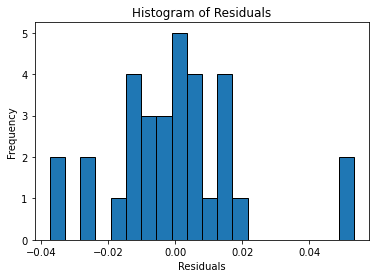

Shapiro-Wilk test statistic: 0.9264308214187622, p-value: 0.031179876998066902


In [122]:
residuals = result.resid
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

In [113]:
df.to_csv('test.csv', index=False)